In [2]:
import tensorflow as tf
from tensorflow import keras

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

original = np.genfromtxt("./로그 데이터/SEG_SGEMM_result.txt", delimiter="\n", dtype=np.int64).reshape(-1, 1)
original = pd.DataFrame(data=original, columns=["SEG"])
data = original.copy()
original

,SEG
0,3196231680
1,93292771632
2,93293300344
3,93293373376
4,93292057424
...,...
237191,92622695528
237192,92622695520
237193,92658792872
237194,92658792864


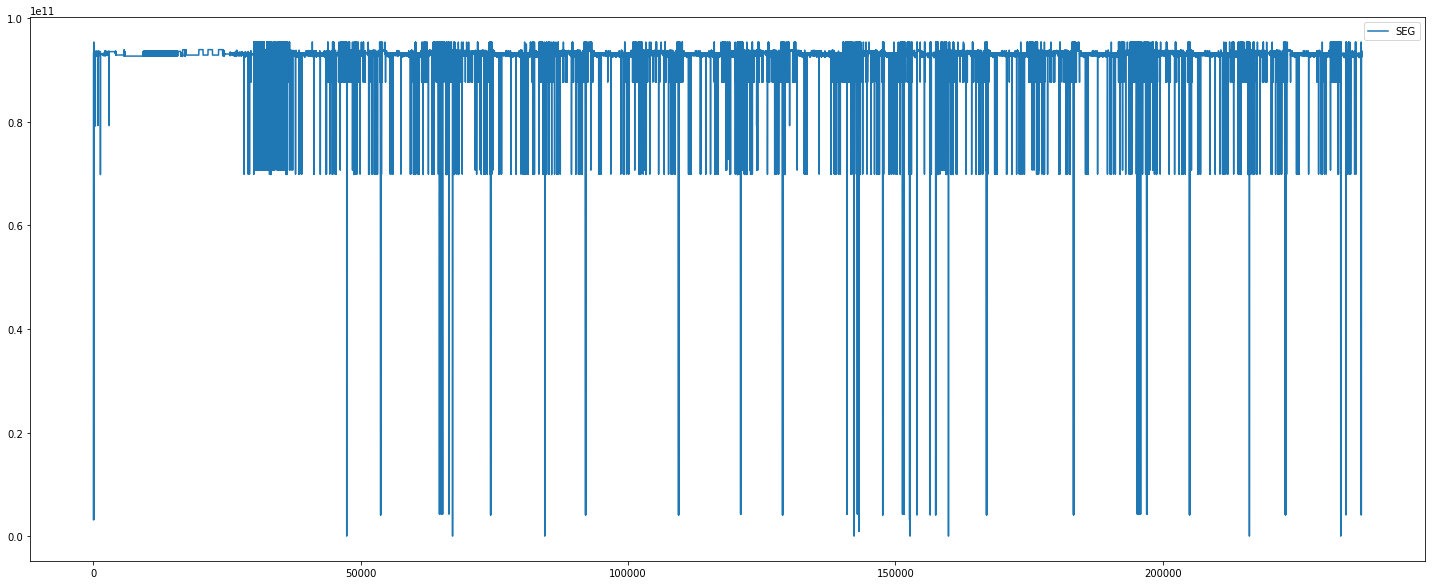

In [4]:
original.plot(figsize=(25, 10))

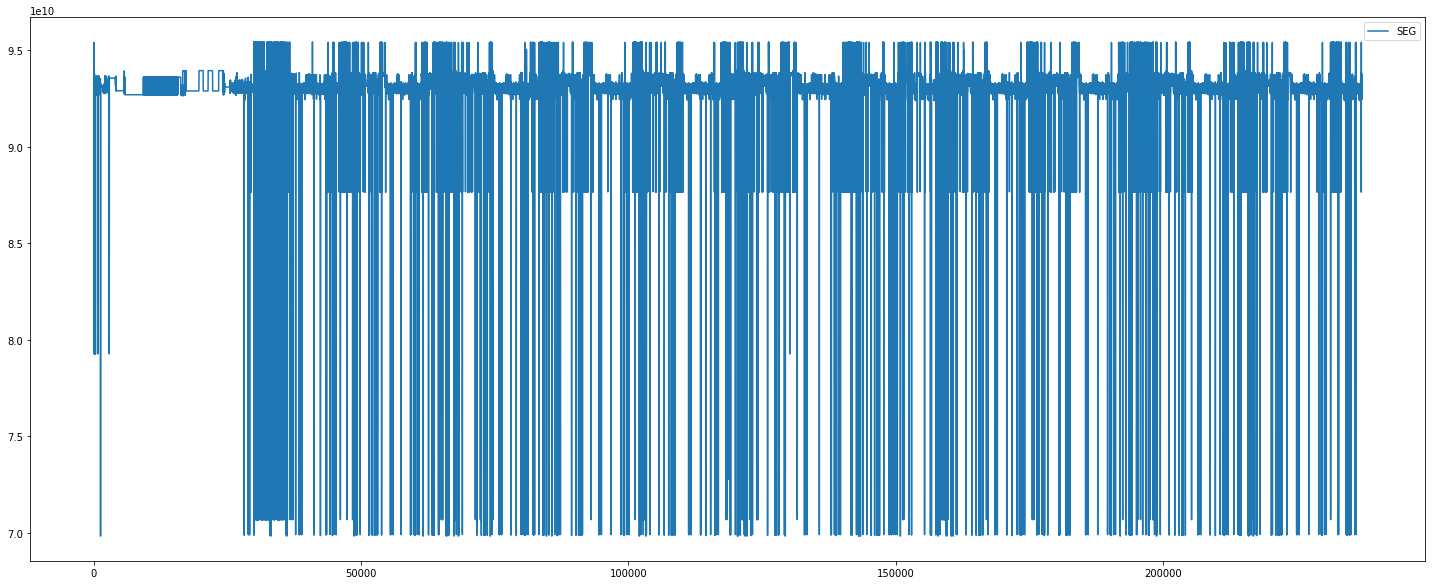

In [5]:
value_range = [(data["SEG"].max() - data["SEG"].min()) / 10 *i for i in range(10)]
docile = (data["SEG"] <= value_range[1])     # Only Remove 1st chunk of deciles
docile_index = docile.index[docile == True]

data = data.drop(index=docile_index)
data.plot(figsize=(25, 10))

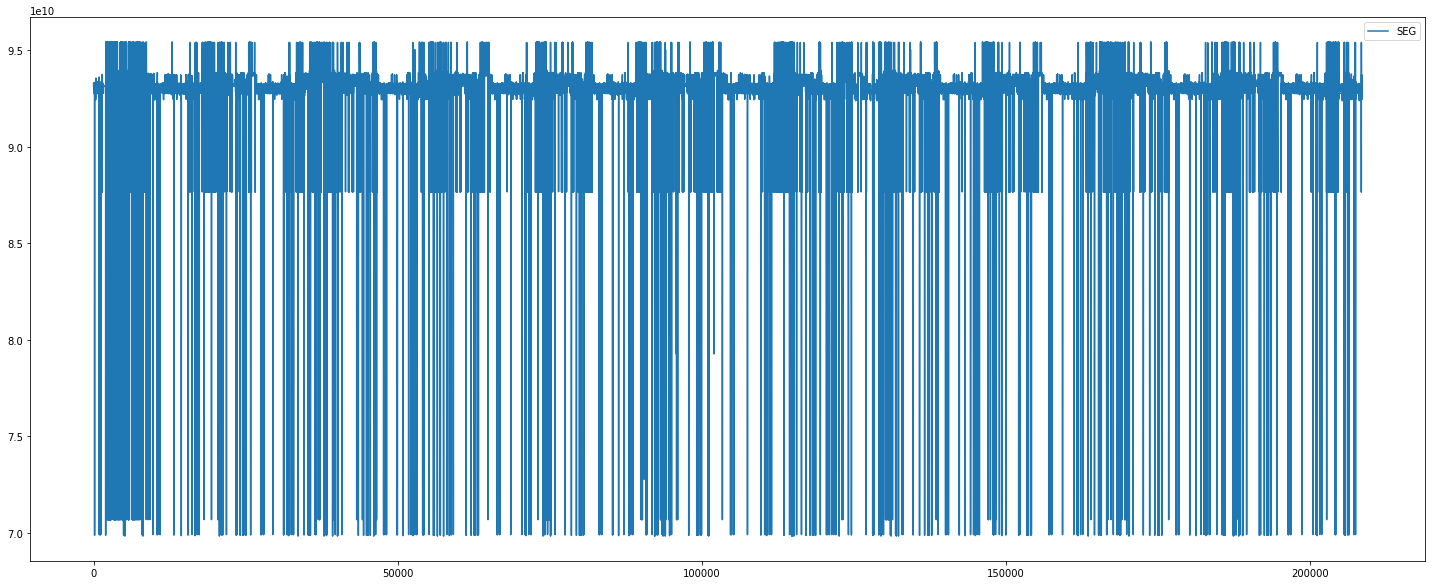

In [6]:
data = data[28000:].reset_index(drop=True)
data.plot(figsize=(25, 10))

In [7]:
def delta_slice(data, step, cutoff=None):
    if cutoff:
        data = data[cutoff:].reset_index(drop=True)
    delta = pd.DataFrame(data=[data.loc[i+step] - data.loc[i] for i in range(int(len(data)/step))])
    return delta

In [8]:
pattern_length = 4

delta = delta_slice(data, pattern_length)
delta

,SEG
0,432584
1,-21321705
2,-56053462
3,87057360
4,-101953016
...,...
52120,303104
52121,-72024064
52122,-75329536
52123,-78336000


In [9]:
split_index = 48000
train_set = delta[:split_index]
test_set = delta[split_index:]
test_set.reset_index(drop=True, inplace=True)
train_set, test_set

(             SEG
 0         432584
 1      -21321705
 2      -56053462
 3       87057360
 4     -101953016
 ...          ...
 47995  -30720000
 47996 -208666624
 47997 -209559552
 47998  -21389312
 47999    8122368
 
 [48000 rows x 1 columns],
             SEG
 0     208703488
 1      20402176
 2    -201752576
 3      -8151040
 4    -178098176
 ...         ...
 4120     303104
 4121  -72024064
 4122  -75329536
 4123  -78336000
 4124  -78278656
 
 [4125 rows x 1 columns])

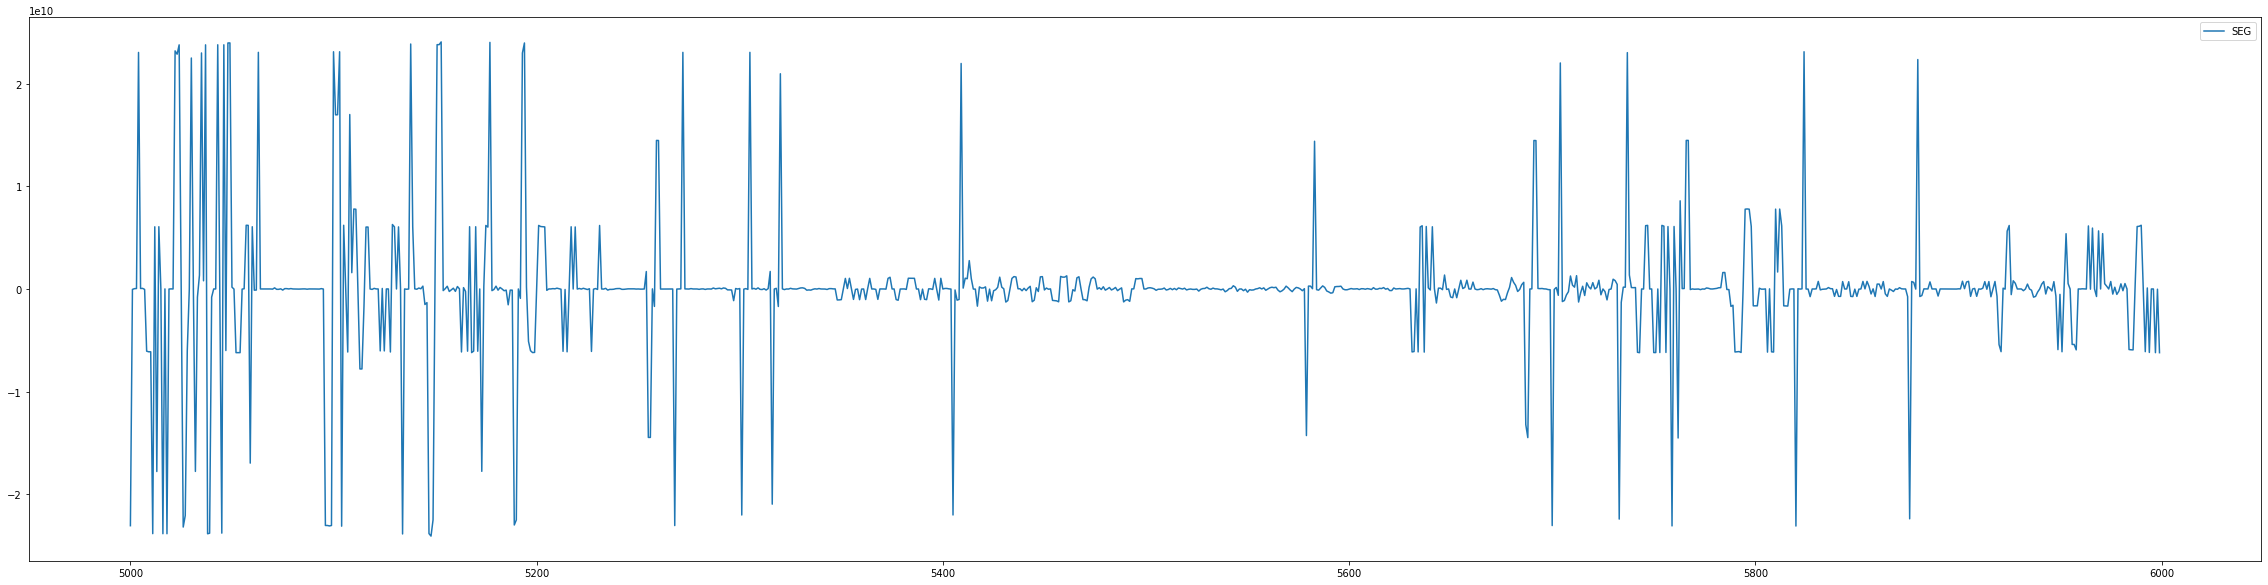

In [10]:
train_set[5000:6000].plot(figsize=(40, 10))

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

train_data = std_scaler.fit_transform(train_set.values)
train_data, std_scaler.mean_, std_scaler.var_

(array([[ 0.00013738],
        [-0.00657383],
        [-0.0172886 ],
        ...,
        [-0.06464534],
        [-0.00659469],
        [ 0.00250968]]),
 array([-12732.32872917]),
 array([1.05072167e+19]))

In [12]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i:i+target_size])
    return np.array(data), np.array(labels)

In [13]:
PAST_HISTORY = 16
FUTURE_TARGET = 8
TRAIN_SPLIT = 40000
BATCH_SIZE = 256
BUFFER_SIZE = 200000

In [14]:
x_train, y_train = univariate_data(train_data, 0, TRAIN_SPLIT, PAST_HISTORY, FUTURE_TARGET)
x_val, y_val = univariate_data(train_data, TRAIN_SPLIT, None, PAST_HISTORY, FUTURE_TARGET)

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.cache().batch(BATCH_SIZE)

In [15]:
x_train.shape, x_train[0], y_train[0], y_train.shape

((39984, 16, 1),
 array([[ 0.00013738],
        [-0.00657383],
        [-0.0172886 ],
        [ 0.02686118],
        [-0.03144865],
        [-0.02309717],
        [-0.04297952],
        [ 0.01554453],
        [ 0.02205236],
        [ 0.03352751],
        [ 0.03039514],
        [ 0.01759532],
        [-0.01214286],
        [-0.05621876],
        [ 0.02587363],
        [-0.03854545]]),
 array([[ 2.14246173e-02],
        [ 5.62481740e-02],
        [-2.62082671e-05],
        [ 8.75716763e-03],
        [-2.14558053e-02],
        [-1.49425658e-02],
        [ 7.99295093e-03],
        [-3.73112073e-05]]),
 (39984, 8, 1))

In [16]:
def plot_graphs(history, metric, title=None):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    if title:
        plt.savefig("result/{0}-{1}.png".format(metric, title), dpi=300)
    plt.show()    

In [17]:
num_neurons_1 = 128
num_neurons_2 = 64
num_neurons_3 = 0
num_neurons_4 = 0
dropout_rate = 0.2

EPOCHS = 1000
EVALUATION_INTERVAL = 200
VAL_STEPS = 50

In [18]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(num_neurons_1, return_sequences=True, input_shape=x_train.shape[-2:]))
#model.add(tf.keras.layers.Dropout(dropout_rate))
model.add(tf.keras.layers.LSTM(num_neurons_2))
#model.add(tf.keras.layers.Dropout(dropout_rate))
#model.add(tf.keras.layers.LSTM(num_neurons_3))
#model.add(tf.keras.layers.Dropout(dropout_rate))
#model.add(tf.keras.layers.LSTM(num_neurons_4))
model.add(tf.keras.layers.Dense(FUTURE_TARGET))
model.add(tf.keras.layers.Dropout(dropout_rate))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [19]:
model_history = model.fit(train_data, epochs=EPOCHS, steps_per_epoch=None, validation_data=val_data)

54/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.3688 - mse: 0.3688 - val_loss: 0.4834 - val_mse: 0.4834
Epoch 255/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.3759 - mse: 0.3759 - val_loss: 0.4756 - val_mse: 0.4756
Epoch 256/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.3819 - mse: 0.3819 - val_loss: 0.4656 - val_mse: 0.4656
Epoch 257/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.3757 - mse: 0.3757 - val_loss: 0.4717 - val_mse: 0.4717
Epoch 258/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.3630 - mse: 0.3630 - val_loss: 0.4712 - val_mse: 0.4712
Epoch 259/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.3673 - mse: 0.3673 - val_loss: 0.4774 - val_mse: 0.4774
Epoch 260/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.3592 - mse: 0.3592 - val_loss: 0.4800 - val_mse: 0.4800
Epoch 261/1000
157/157 [==============================]

KeyboardInterrupt: 

In [1]:
title = '{0}-{1}-{2}_{3}_{4}_{5}-{6}'.format(EPOCHS, BATCH_SIZE, num_neurons_1, num_neurons_2, num_neurons_3, num_neurons_4, str(dropout_rate))
pd.DataFrame.from_dict(model_history.history).to_csv("result/{0}.csv".format(title), index=False)
plot_graphs(model_history, 'mse', title)
plot_graphs(model_history, 'loss', title)

NameError: name 'EPOCHS' is not defined

In [363]:
test_data = delta_slice(test_set, pattern_length)
test_data = std_scaler.transform(test_data)
x_test, y_test = univariate_data(test_data, 0, None, PAST_HISTORY, FUTURE_TARGET)
x_test[0]

array([[-0.11932466],
       [-0.0125893 ],
       [ 0.07330772],
       [ 0.0025438 ],
       [ 0.04551316],
       [ 0.01572966],
       [-0.01268154],
       [ 0.00246419],
       [ 0.02056427],
       [-0.01893772],
       [ 0.00330955],
       [-0.00502148],
       [-0.01103505],
       [ 0.01893167],
       [-0.00346344],
       [ 0.01206391]])

In [398]:
from sklearn.metrics import mean_squared_error

def plot_test_error(model, x_test, y_test, title=None):
    test_errors = []
    for x, y in zip(x_test, y_test):
        x_pred = model.predict(x.reshape(1, -1, 1))
        test_errors.append(mean_squared_error(y.reshape(1, -1), x_pred))
    plt.plot(test_errors, "r-+")
    plt.ylabel("Test MSE")
    if title:
        plt.savefig("result/test_mse-{0}.png".format(title), dpi=300)
    plt.show()    

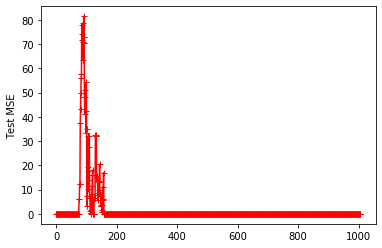

In [399]:
plot_test_error(model, x_test, y_test, title)

In [400]:
x_test.shape

(1007, 16, 1)